In [1]:
import numpy as np
import pandas as pd 
import pandas_ta as ta
import yfinance as yf
import sqlite3 

* DX-Y.NYB: US Dollar Index
* ^VIX: CBOE Volatility Index

In [85]:
conn = sqlite3.connect("../database.db")
stock_df = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = 'AAPL'", con=conn)
stock_df = stock_df.drop(columns=["ID", "Volume", "Ticker", "InsertTime"])
# stock_df = stock_df.set_index("Datetime")

stock_df

,Datetime,Open,High,Low,Close
0,2016-02-16 00:00:00.000000,21.520171,21.934630,21.427315,21.887070
1,2016-02-17 00:00:00.000000,21.893869,22.242650,21.776100,22.222267
2,2016-02-18 00:00:00.000000,22.385332,22.396657,21.762511,21.801014
3,2016-02-19 00:00:00.000000,21.742121,21.914247,21.696826,21.751181
4,2016-02-22 00:00:00.000000,21.812332,21.945956,21.724004,21.941425
...,...,...,...,...,...
2510,2026-02-09 00:00:00.000000,277.910004,278.200012,271.700012,274.619995
2511,2026-02-10 00:00:00.000000,274.890015,275.369995,272.940002,273.679993
2512,2026-02-11 00:00:00.000000,274.700012,280.179993,274.450012,275.500000
2513,2026-02-12 00:00:00.000000,275.589996,275.720001,260.179993,261.730011


### Denoising the data

"We have applied the soft mode of the Haar wavelets using python library scikit-image to denoise the close price of the index." (page 15)

In [86]:
from skimage.restoration import denoise_wavelet, estimate_sigma

train_size=2000
val_size=250

cols = stock_df.shape[1]

sigmas = []
for i in range(cols):
    if i == 0:
        sigmas.append(0)
    else:
        inner_sigma = estimate_sigma(stock_df.iloc[:train_size, i], channel_axis=None)
        sigmas.append(inner_sigma)

def denoise_df(df):
    inner_df = df.copy()

    train_df = inner_df.iloc[:train_size, :]
    val_df = inner_df.iloc[train_size:train_size+val_size, :]
    test_df = inner_df.iloc[train_size+val_size:, :]


    for i in range(cols):
        if i > 0:
            train_df.iloc[:, i] = denoise_wavelet(
                train_df.iloc[:, i],
                wavelet="haar", 
                mode="soft",
                sigma=sigmas[i],
                rescale_sigma=True,
                channel_axis=None
            )

            val_df.iloc[:, i] = denoise_wavelet(
                val_df.iloc[:, i],
                wavelet="haar", 
                mode="soft",
                sigma=sigmas[i],
                rescale_sigma=True,
                channel_axis=None
            )

            test_df.iloc[:, i] = denoise_wavelet(
                test_df.iloc[:, i],
                wavelet="haar", 
                mode="soft",
                sigma=sigmas[i],
                rescale_sigma=True,
                channel_axis=None
            )

    inner_df = pd.concat([train_df, val_df, test_df])

    return inner_df
# train_denoised, sigma = denoise_wavelet(
#     train_df, 
#     wavelet="haar",
#     mode="soft", 
#     rescale_sigma=True,
#     channel_axis=None,
#     sigma=None,
#     convert2ycbcr=False,
#     method="BayesShrink",
#     return_sigma=True
# )

In [87]:
stock_df = denoise_df(stock_df)

In [88]:
stock_df["Datetime"] = pd.to_datetime(stock_df["Datetime"])

stock_df["MACD"] = ta.macd(stock_df.Close).iloc[:, 0]
stock_df["ATR"] = ta.atr(stock_df.High, stock_df.Low, stock_df.Close)
stock_df["RSI"] = ta.rsi(stock_df.Close)


stock_df = stock_df.drop(columns=["High", "Low"])
stock_df = stock_df.dropna()
stock_df

,Datetime,Open,Close,MACD,ATR,RSI
25,2016-03-22,23.971541,24.043876,0.746292,0.420347,93.497497
26,2016-03-23,23.971541,24.043876,0.731743,0.416558,93.497497
27,2016-03-24,23.971541,24.043876,0.712006,0.413040,93.497497
28,2016-03-28,23.922835,24.028484,0.687200,0.413593,92.101703
29,2016-03-29,23.922835,24.253541,0.677887,0.419021,93.605019
...,...,...,...,...,...,...
2510,2026-02-09,277.779927,274.526863,2.664099,6.000097,63.526365
2511,2026-02-10,274.915748,273.716942,2.935896,5.757229,62.075254
2512,2026-02-11,274.792349,275.474630,3.255600,5.802039,63.997307
2513,2026-02-12,275.526523,261.834722,2.380895,6.493877,44.956370


In [89]:
unemployment = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'URATE'", con=conn)
inflation = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'IRATE'", con=conn)
consumer_sentiment = pd.read_sql("SELECT * FROM Macroeconomic_Data WHERE Metric = 'CSI'", con=conn)
usd_index = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = 'DX-Y.NYB'", con=conn)
cboe_vol = pd.read_sql("SELECT * FROM Ticker_1D WHERE Ticker = '^VIX'", con=conn) 

In [90]:
unemployment["Datetime"] = pd.to_datetime(unemployment["Datetime"])
inflation["Datetime"] = pd.to_datetime(inflation["Datetime"])
consumer_sentiment["Datetime"] = pd.to_datetime(consumer_sentiment["Datetime"])
usd_index["Datetime"] = pd.to_datetime(usd_index["Datetime"])
cboe_vol["Datetime"] = pd.to_datetime(cboe_vol["Datetime"])

In [91]:
len(unemployment), len(inflation), len(consumer_sentiment), len(usd_index), len(cboe_vol)

(121, 121, 121, 2515, 2515)

### Combining the data

In [92]:
import duckdb

In [93]:
df = duckdb.query(
"""
SELECT A.*, URATE, IRATE, CSI, USDX, CBOE FROM 
(

    SELECT * FROM stock_df

) AS A LEFT JOIN 
(
    SELECT Datetime, Rate AS 'URATE' FROM unemployment
) AS B ON A.Datetime = B.Datetime LEFT JOIN 
(
    SELECT Datetime, Rate AS 'IRATE' FROM inflation
) AS C ON A.Datetime = C.Datetime LEFT JOIN 
(
    SELECT Datetime, Rate AS 'CSI' FROM consumer_sentiment
) AS D ON A.Datetime = D.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'USDX' FROM usd_index
) AS E ON A.Datetime = E.Datetime LEFT JOIN 
(
    SELECT Datetime, Close AS 'CBOE' FROM cboe_vol
) AS F ON A.Datetime = F.Datetime

"""
).to_df()

df = df.set_index("Datetime", drop=True)
df = df.sort_index()
df

,Open,Close,MACD,ATR,RSI,URATE,IRATE,CSI,USDX,CBOE
Datetime,,,,,,,,,,
2016-03-22,23.971541,24.043876,0.746292,0.420347,93.497497,NaN,NaN,NaN,95.650002,14.170000
2016-03-23,23.971541,24.043876,0.731743,0.416558,93.497497,NaN,NaN,NaN,96.050003,14.940000
2016-03-24,23.971541,24.043876,0.712006,0.413040,93.497497,NaN,NaN,NaN,96.139999,14.740000
2016-03-28,23.922835,24.028484,0.687200,0.413593,92.101703,NaN,NaN,NaN,95.940002,15.240000
2016-03-29,23.922835,24.253541,0.677887,0.419021,93.605019,NaN,NaN,NaN,95.160004,13.820000
...,...,...,...,...,...,...,...,...,...,...
2026-02-09,277.779927,274.526863,2.664099,6.000097,63.526365,NaN,NaN,NaN,96.820000,17.360001
2026-02-10,274.915748,273.716942,2.935896,5.757229,62.075254,NaN,NaN,NaN,96.800003,17.790001
2026-02-11,274.792349,275.474630,3.255600,5.802039,63.997307,NaN,NaN,NaN,96.830002,17.650000


In [94]:
df = df.ffill()
df = df.bfill()
df

,Open,Close,MACD,ATR,RSI,URATE,IRATE,CSI,USDX,CBOE
Datetime,,,,,,,,,,
2016-03-22,23.971541,24.043876,0.746292,0.420347,93.497497,5.1,0.37,89.0,95.650002,14.170000
2016-03-23,23.971541,24.043876,0.731743,0.416558,93.497497,5.1,0.37,89.0,96.050003,14.940000
2016-03-24,23.971541,24.043876,0.712006,0.413040,93.497497,5.1,0.37,89.0,96.139999,14.740000
2016-03-28,23.922835,24.028484,0.687200,0.413593,92.101703,5.1,0.37,89.0,95.940002,15.240000
2016-03-29,23.922835,24.253541,0.677887,0.419021,93.605019,5.1,0.37,89.0,95.160004,13.820000
...,...,...,...,...,...,...,...,...,...,...
2026-02-09,277.779927,274.526863,2.664099,6.000097,63.526365,4.4,3.72,52.9,96.820000,17.360001
2026-02-10,274.915748,273.716942,2.935896,5.757229,62.075254,4.4,3.72,52.9,96.800003,17.790001
2026-02-11,274.792349,275.474630,3.255600,5.802039,63.997307,4.4,3.72,52.9,96.830002,17.650000


## Analyzing the data

<Axes: >

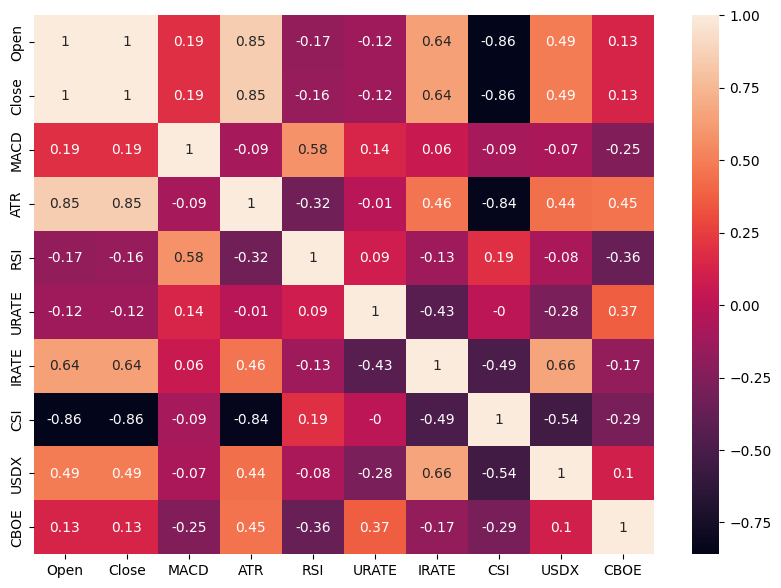

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
df_corr = df.corr().round(2)
sns.heatmap(df_corr, annot=True)

In [96]:
df = df.drop("Open", axis=1) # High Correlation
df

,Close,MACD,ATR,RSI,URATE,IRATE,CSI,USDX,CBOE
Datetime,,,,,,,,,
2016-03-22,24.043876,0.746292,0.420347,93.497497,5.1,0.37,89.0,95.650002,14.170000
2016-03-23,24.043876,0.731743,0.416558,93.497497,5.1,0.37,89.0,96.050003,14.940000
2016-03-24,24.043876,0.712006,0.413040,93.497497,5.1,0.37,89.0,96.139999,14.740000
2016-03-28,24.028484,0.687200,0.413593,92.101703,5.1,0.37,89.0,95.940002,15.240000
2016-03-29,24.253541,0.677887,0.419021,93.605019,5.1,0.37,89.0,95.160004,13.820000
...,...,...,...,...,...,...,...,...,...
2026-02-09,274.526863,2.664099,6.000097,63.526365,4.4,3.72,52.9,96.820000,17.360001
2026-02-10,273.716942,2.935896,5.757229,62.075254,4.4,3.72,52.9,96.800003,17.790001
2026-02-11,275.474630,3.255600,5.802039,63.997307,4.4,3.72,52.9,96.830002,17.650000


### Denoising the data

I don't want this model to have lookahead bias, so I start by defining train, validation, and testing `dfs`. 

In [100]:
from sklearn.preprocessing import MinMaxScaler

X = df.drop("Close", axis=1)
y = df[["Close"]]

X_scaler = MinMaxScaler()
y_scaler= MinMaxScaler()

X_scaler.fit(X.iloc[:train_size, :])
y_scaler.fit(y.iloc[:train_size, :])

def scale_df(X, y):
    inner_X = X.copy()
    inner_y = y.copy()

    X_train = X_scaler.transform(inner_X.iloc[:train_size, :])
    X_val = X_scaler.transform(inner_X.iloc[train_size:train_size+val_size, :])
    X_test = X_scaler.transform(inner_X.iloc[train_size+val_size:, :])

    y_train = y_scaler.transform(inner_y.iloc[:train_size, :])
    y_val = y_scaler.transform(inner_y.iloc[train_size:train_size+val_size, :])
    y_test = y_scaler.transform(inner_y.iloc[train_size+val_size:, :])

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = scale_df(X, y)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((2000, 8), (250, 8), (240, 8), (2000, 1), (250, 1), (240, 1))